In [22]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dict_keys(['__header__', '__version__', '__globals__', 'data_train'])
(301, 33)
0


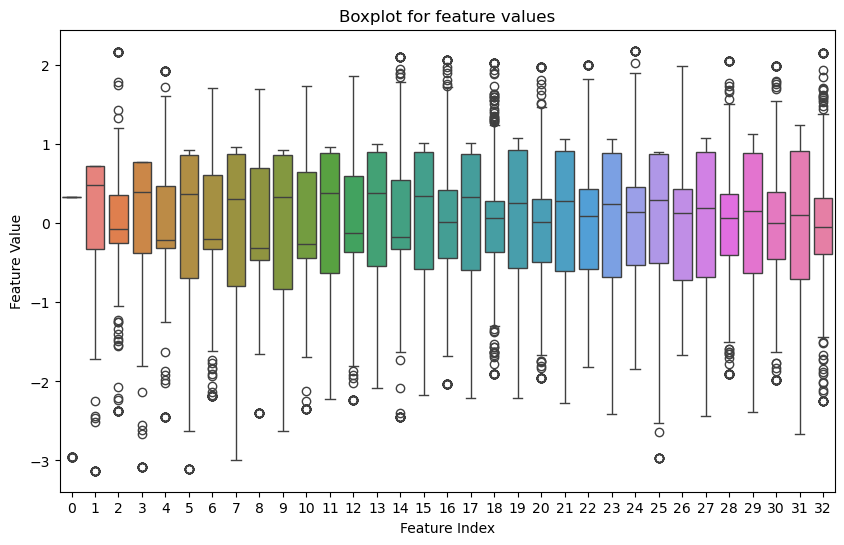

dict_keys(['__header__', '__version__', '__globals__', 'label_train'])
(301, 1)


array([-1,  1], dtype=int16)

In [23]:
data_tr=scipy.io.loadmat('data_train.mat')
data_te=scipy.io.loadmat('data_test.mat')
label_tr=scipy.io.loadmat('label_train.mat')

print(data_tr.keys())
X=data_tr['data_train']
print(X.shape)
print(np.isnan(X).sum())
X=(X-X.mean(axis=0))/X.std(axis=0)
#outlier check
plt.figure(figsize=(10,6))
sns.boxplot(data=X)
plt.title('Boxplot for feature values')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.show()

print(label_tr.keys())
y=label_tr['label_train']
print(y.shape)

X_test=data_te['data_test']
X_test=(X_test-X_test.mean(axis=0))/X_test.std(axis=0)

##judge the distribution of labels
np.unique(y)


## Input Layer
Since the train data have 33 features, the input layer should have 33 neurons.

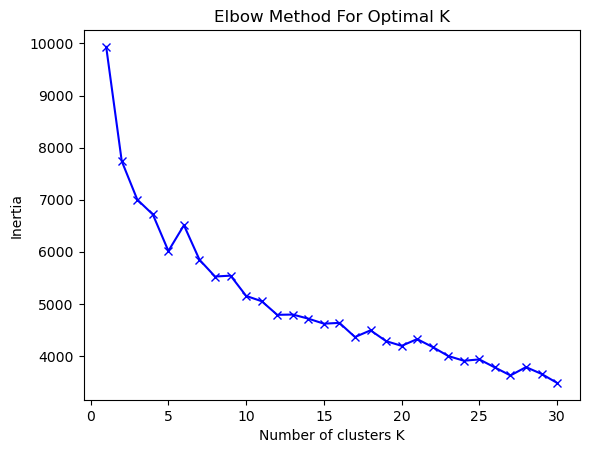

In [24]:
## Neuron centres selection
## Kmeans method
class ncs_Kmeans:
    def __init__ (self, X, n_clusters, max_iters=10000):
        ##standerlize
        self.X=(X-X.mean(axis=0))/X.std(axis=0)
        self.n_clusters=n_clusters
        self.max_iters=max_iters
        self.n_samples, n_features=X.shape

    def distance(self, a, b):
        return np.linalg.norm(a-b, axis=1)
    
    def fit(self):
        ##randomly select initial centres
        random_indices=np.random.choice(self.n_samples, self.n_clusters, replace=False)
        self.centres=self.X[random_indices]

        for _ in range(self.max_iters):
            #assign clusters
            clusters=[]
            for x in self.X:
                distances=self.distance(x, self.centres)
                cluster=np.argmin(distances)
                clusters.append(cluster)
            clusters=np.array(clusters)

            #update centres
            new_centres=[]
            for i in range(self.n_clusters):
                points=self.X[clusters==i]
                new_centre=points.mean(axis=0)
                new_centres.append(new_centre)
            new_centres=np.array(new_centres)

            #check convergence
            if np.all(self.centres==new_centres):
                break
            self.centres=new_centres

        self.clusters=clusters
        return self.centres, self.clusters
## elbow method to select number of clusters  
inertias=[]
K=range(1,31)
for k in K:
    kmeans=ncs_Kmeans(X, n_clusters=k)
    centres, clusters=kmeans.fit()
    inertia=0
    for i in range(k):
        points=X[clusters==i]
        inertia+=np.sum((points - centres[i])**2)
    inertias.append(inertia)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

In [43]:
##select k=8
kmeans=ncs_Kmeans(X, n_clusters=8)
centres, clusters=kmeans.fit()
print("Centres shape:", centres.shape)

def distance(a,b):
    return np.linalg.norm(a-b)

class RBFNN:
    def __init__(self, X, centres, sigma):
        self.X=X
        self.centres=centres
        self.sigma=sigma
        self.n_centres=centres.shape[0]
    
    def gaussian_rbf(self,x,centre):
        return np.exp(-np.linalg.norm(x-centre)**2/(2*self.sigma**2))
    
    def hidden_layer_activation(self):
        n_samples=self.X.shape[0]
        H=np.zeros((n_samples, self.n_centres))
        for i in range(n_samples):
            for j in range(self.n_centres):
                H[i,j]=self.gaussian_rbf(self.X[i], self.centres[j])
        return H
    
    def train(self,y):
        H=self.hidden_layer_activation()
        H_bias=np.hstack((np.ones((H.shape[0],1)), H))
        self.weights=np.linalg.pinv(H_bias).dot(y)
        self.W=self.weights

    def predict(self, X_test):
        n_samples=X_test.shape[0]
        H_test=np.zeros((n_samples, self.n_centres))
        for i in range(n_samples):
            for j in range(self.n_centres):
                H_test[i,j]=self.gaussian_rbf(X_test[i], self.centres[j])
        H_test_bias=np.hstack((np.ones((H_test.shape[0],1)), H_test))
        y_temp=H_test_bias.dot(self.weights)
        y_pred=np.where(y_temp>=0,1,-1)
        self.H=H_test_bias
        return y_pred
    
    ##check coverage and sigma
    def check(self):
        return self.W, self.H
        

##compute sigma with d_{max}/sqrt(2*n_centres)
d_max=0
for i in range(centres.shape[0]):
    for j in range(i+1, centres.shape[0]):
        d=distance(centres[i], centres[j])
        if d>d_max:
            d_max=d
sigma=d_max/np.sqrt(2*centres.shape[0])
print("Sigma:", sigma)
rbfnn=RBFNN(X, centres, sigma)
rbfnn.train(y)
y_pred=rbfnn.predict(X_test)

np.unique(y_pred, return_counts=True)

W,H=rbfnn.check()

print("Weights:", W.flatten())

print(f"Prediction:{y_pred.flatten()}")

Centres shape: (8, 33)
Sigma: 2.3507982810446713
Weights: [-0.50432602  1.39977167 -1.16360778  2.42098868  0.22466202 -4.58923161
 -7.07185452  1.31316255  2.35189815]
Prediction:[-1  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1
 -1  1 -1  1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1
  1  1]


In [26]:
##evaluation use train
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
y_train_pred=rbfnn.predict(X)
print("Confusion Matrix:")
print(confusion_matrix(y, y_train_pred))
print("Accuracy:", accuracy_score(y, y_train_pred))
print("Precision:", precision_score(y, y_train_pred, average='macro'))
print("Recall:", recall_score(y, y_train_pred, average='macro'))
print("F1 Score:", f1_score(y, y_train_pred, average='macro'))

W,H=rbfnn.check()
import numpy as np
from scipy.spatial.distance import cdist

# 1. 计算所有训练样本到所有中心的距离矩阵 (301, 12)
dists = cdist(X, centres, 'euclidean')

# 2. 检查量化误差 (每个样本到其最近中心的距离)
min_dists = np.min(dists, axis=1)
avg_quantization_error = np.mean(min_dists)

# 3. 检查激活强度 (H 矩阵)
# 使用你定义的 gaussian_rbf 逻辑计算 H
max_activations = np.max(H, axis=1)

print("--- Coverage 诊断报告 ---")
print(f"1. 平均量化误差: {avg_quantization_error:.4f} (样本到最近中心的平均距离)")
print(f"2. 当前 Sigma: {sigma:.4f}")

# 诊断逻辑：
# 如果 min_dist > 3 * sigma，说明该样本落在感应区边缘，覆盖较差
poor_coverage_count = np.sum(min_dists > 3 * sigma)
print(f"3. 覆盖较差的样本数 (距离 > 3σ): {poor_coverage_count} / {len(X)}")

# 如果 max_activation < 0.1，说明存在“激活盲区”
blind_spots = np.sum(max_activations < 0.1)
print(f"4. 激活盲区数 (最大激活度 < 0.1): {blind_spots}")



Confusion Matrix:
[[ 97   9]
 [ 15 180]]
Accuracy: 0.920265780730897
Precision: 0.9092261904761905
Recall: 0.9190856313497824
F1 Score: 0.913704128440367
--- Coverage 诊断报告 ---
1. 平均量化误差: 3.4915 (样本到最近中心的平均距离)
2. 当前 Sigma: 2.9702
3. 覆盖较差的样本数 (距离 > 3σ): 14 / 301
4. 激活盲区数 (最大激活度 < 0.1): 0


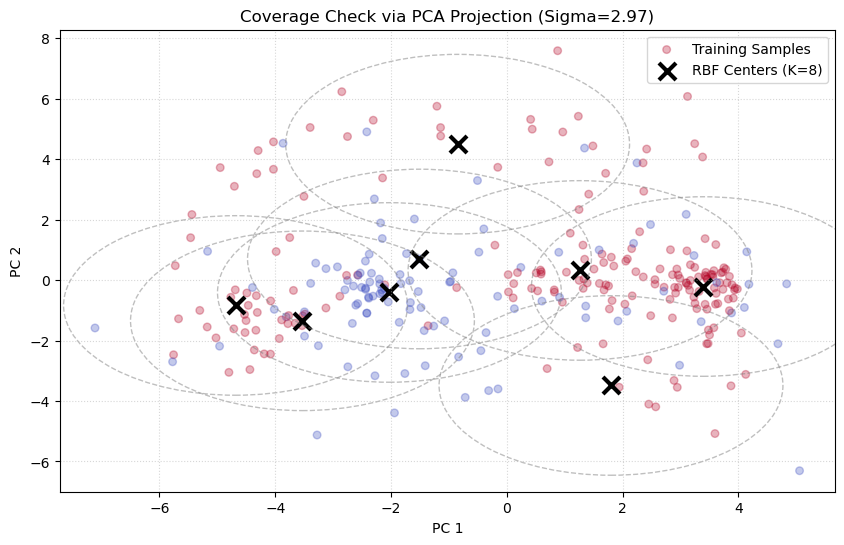

In [27]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)      # 训练数据投影
C_pca = pca.transform(centres)    # 中心点投影

# Draw
plt.figure(figsize=(10, 6))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.flatten(), cmap='coolwarm', 
            alpha=0.3, s=30, label='Training Samples')

plt.scatter(C_pca[:, 0], C_pca[:, 1], c='black', marker='x', 
            s=150, linewidths=3, label=f'RBF Centers (K={rbfnn.n_centres})')

for i in range(C_pca.shape[0]):
    circle = plt.Circle((C_pca[i, 0], C_pca[i, 1]), sigma, color='gray', 
                        fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_artist(circle)
plt.title(f"Coverage Check via PCA Projection (Sigma={sigma:.2f})")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

In [38]:
import numpy as np
import sys
import os

print(f"当前 NumPy 版本: {np.__version__}")
print(f"Python 执行路径: {sys.executable}")
print(f"NumPy 库安装路径: {os.path.dirname(np.__file__)}")


当前 NumPy 版本: 2.2.6
Python 执行路径: /Users/zimin/opt/miniconda3/envs/Research/bin/python
NumPy 库安装路径: /Users/zimin/opt/miniconda3/envs/Research/lib/python3.11/site-packages/numpy


In [44]:
#use backpropogation to adjust sigma and weights
import torch
import torch.nn as nn

class RBFNet(nn.Module):
    def __init__(self, centers, sigma):
        super(RBFNet, self).__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigma = nn.Parameter(torch.tensor(sigma, dtype=torch.float32))
        self.weights = nn.Linear(centers.shape[0], 1)
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers)
        out = torch.exp(-dists**2 / (2 * self.sigma**2))
        return self.weights(out)
    
model = RBFNet(centres, sigma)
criterion = nn.HuberLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# 确保 y 的形状是 (N, 1) 以匹配 Linear 层的输出
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# 如果你之前没有对 X_test 做处理，这里也准备好
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

Epoch [100/1000], Loss: 0.0410
Epoch [200/1000], Loss: 0.0393
Epoch [300/1000], Loss: 0.0379
Epoch [400/1000], Loss: 0.0365
Epoch [500/1000], Loss: 0.0352
Epoch [600/1000], Loss: 0.0339
Epoch [700/1000], Loss: 0.0326
Epoch [800/1000], Loss: 0.0313
Epoch [900/1000], Loss: 0.0301
Epoch [1000/1000], Loss: 0.0288
训练集最终准确率: 99.34%
测试集预测结果: tensor([-1,  1,  1, -1,  1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1,
        -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])
Final Weights: [ 3.61513853 -7.00744486  5.26070595  7.39468384 -6.49602127 -8.55472755
  2.49122381  6.0981431 ]
Final Sigma: 3.611128807067871


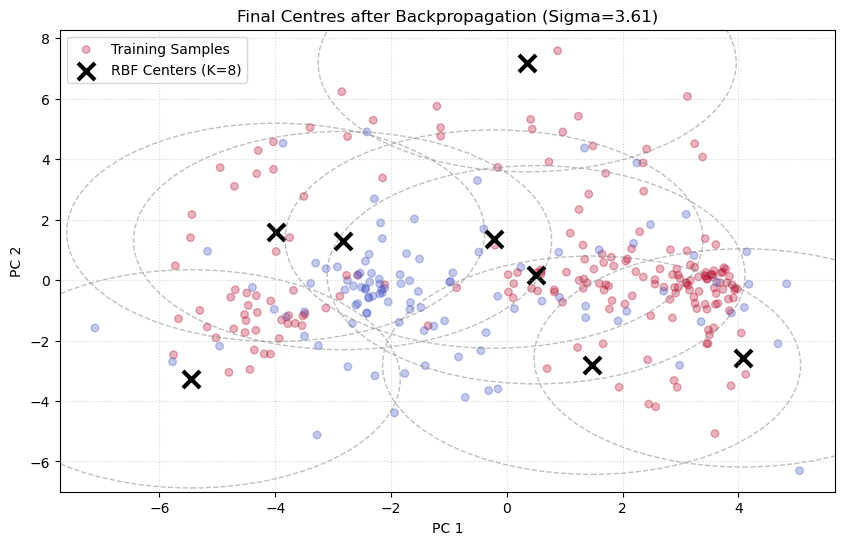

In [46]:
import numpy

epochs = 1000  # 迭代次数
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # 前向传播
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    # 反向传播与优化
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 训练完成后切换到评估模式
model.eval()
with torch.no_grad():
    # --- 训练集测试 ---
    train_outputs = model(X_tensor)
    # 将连续值映射为 1 或 -1
    train_preds = torch.where(train_outputs >= 0, 1, -1)
    train_acc = (train_preds == y_tensor).float().mean()
    print(f"训练集最终准确率: {train_acc.item() * 100:.2f}%")
    
    # --- 测试集预测 (Assignment 最终结果) ---
    test_outputs = model(X_test_tensor)
    y_test_final = torch.where(test_outputs >= 0, 1, -1)

    print(f"测试集预测结果: {y_test_final.flatten()}")


#show weights, sigma and centres position
final_weights=np.array(model.weights.weight.data.tolist()[0])
final_sigma=np.array(model.sigma.data.tolist())
final_centres=np.array(model.centers.data.tolist())
print("Final Weights:", final_weights)
print("Final Sigma:", final_sigma)
##plot centres position
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)      # 训练数据投影
C_pca = pca.transform(final_centres)    # 中心点投影
# Draw
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.flatten(), cmap='coolwarm', 
            alpha=0.3, s=30, label='Training Samples')
plt.scatter(C_pca[:, 0], C_pca[:, 1], c='black', marker='x',
            s=150, linewidths=3, label=f'RBF Centers (K={final_centres.shape[0]})')
for i in range(C_pca.shape[0]):
    circle = plt.Circle((C_pca[i, 0], C_pca[i, 1]), final_sigma.item(), color='gray', 
                        fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_artist(circle)
plt.title(f"Final Centres after Backpropagation (Sigma={final_sigma.item():.2f})")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()  
